In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy.stats import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import hashlib

from matplotlib import pyplot as plt
# from datasketch import MinHash, Simhash
import utils
from similarity_analysis import *

import warnings
warnings.filterwarnings('ignore')

c:\Users\pywong\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The cosine similarity of the document characteristic matrix has a positive correlation to the Jaccard similarity of the signature matrix.

In [2]:
# pick a target document to compare
target_doc_num = 0

# input feature size (number of token used)
feature_size = 2**12
random.seed(10)

# input folder
data_root = os.path.join(os.getcwd(),'input')

In [3]:
df = utils.load_data_from_local(data_root)

Meta data size: 9022
c:\Users\pywong\Desktop\PolyU\COMP5434 Big Data Computing\Assignment\COMP5434-Big-Data-Computing\input\subset\subset\document_parses\pdf_json
total json files: 12000


100%|██████████| 8083/8083 [00:39<00:00, 206.93it/s]
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pywong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy.stats import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import hashlib

from matplotlib import pyplot as plt
# from datasketch import MinHash, Simhash
import utils

import warnings
warnings.filterwarnings('ignore')


def check_document_similarity(X,df,target_doc_num):
    '''
    Given the target document number, return the similarity to other documents.
    Output is a pandas dataframe with number of document as number of row.
    '''
    
    target_doc = X.T[target_doc_num]
    target_doc_norm = np.linalg.norm(target_doc)
    
    doc_l2_norm_list = []
    doc_l1_norm_list = []
    doc_cosine_list = []
    
    # Similarity from characteristic matrix X
    # X is 4096(feature) x 8041(document)
    
    for doc in X.T:
        doc_norm = np.linalg.norm(doc)
        doc_l2_norm = np.linalg.norm(target_doc - doc)
        doc_l1_norm = np.linalg.norm(target_doc - doc,ord=1)
        doc_cosine = doc@target_doc.T/(doc_norm*target_doc_norm)

        doc_l2_norm_list.append(doc_l2_norm)
        doc_l1_norm_list.append(doc_l1_norm)
        doc_cosine_list.append(doc_cosine)

    
    result = pd.DataFrame(
        {
            'doc_l1_norm':doc_l1_norm_list,
            'doc_l2_norm':doc_l2_norm_list,
            'doc_cosine_similarity':doc_cosine_list,
            # 'sig_cosine_similarity':sig_cosine_list,
            # 'sig_jaccard_similarity':sig_jaccard_list
        }
    )
    
    result = result.reset_index().rename(columns={'index':'doc_num'})
    result = pd.concat([result,df[['paper_id','body_text']]],axis=1)
    
    return result

def get_permutate_matrix(X,num_perm=50):
    
    '''
    Return premutation matrix with size:
    number of feature x number of permutation
    '''
    
    N = len(X) # number of features

    p = []

    for i in range(0,num_perm):
        a = random.randint(0, N-1)
        b = random.randint(0, N-1)
        
        new_order = np.array([])
        not_used = list(range(1,N+1))
        
        for j in range(0,N):
            # Buckets are set to be 1 to N
            hash_value = (a*j+b)%N+1
            
            # When 2 hashes mapped to the same bucket, the second hash move to the next bucket.
            while hash_value not in not_used:
                hash_value += 1
                if hash_value > N:
                    hash_value = 1

            not_used.remove(hash_value)
            new_order = np.append(new_order,hash_value)
              
        p.append(new_order)
        
    p = np.array(p).T
    
    return p

def get_minhash_signature(X,p):
    '''
    Return signature matrix with size: number of permutation x number of document
    '''

    s = []
    
    # X is 4096(feature) x 8041(document)
    # p is 4096(feature) x 50 (permutation)
    # Create a signature matrix with size as number of permutation x number of document

    for perm in p.T:
        doc_sig = np.array([])
        for doc in X.T:
            sig_set = set(np.multiply(doc,perm))
            sig_set.discard(0)
            sig = min(sig_set)
            doc_sig = np.append(doc_sig,sig)
            
        s.append(doc_sig)

    s = np.array(s)
    
    return s

def check_minhash_similarity(s,target_doc_num):

    sig_jaccard_list = []
    sig_cosine_list = []
    
    # Similarity from signature matrix
    # s is 50(permutation) x 8041(document)
    
    target_sig = s.T[target_doc_num]
    target_sig_norm = np.linalg.norm(target_sig)
    
    # loop through all document to create a list of score
    for sig in s.T:
        sig_norm = np.linalg.norm(sig)
        sig_cosine = (sig @ target_sig.T)/(sig_norm*target_sig_norm)
        sig_cosine_list.append(sig_cosine)

        sig_intersection = len(list(set(target_sig).intersection(sig)))
        sig_union = (len(set(target_sig)) + len(set(sig))) - sig_intersection
        sig_jaccard = sig_intersection / sig_union
        sig_jaccard_list.append(sig_jaccard)   
        
    df = pd.DataFrame(
        {
            'sig_cosine_similarity':sig_cosine_list,
            'sig_jaccard_similarity':sig_jaccard_list
        }
    )
    
    df = df.reset_index().rename(columns={'index':'doc_num'})
    
    return df


def get_feature_hash(feature_list):
        
    feature_hash = []
    max_bit_size = 0
    
    for feature_name in feature_list:        
        # Use MD5 or SHA1 to encode, since these hash functions are localicity sensitive
        # Convert the integer into string of 0 or 1 as a hash.
        
        encod_feature = str.encode(feature_name)
        
        # MD5
        feature_byte = hashlib.md5(encod_feature).digest()
        feature_int = int.from_bytes(feature_byte, byteorder='little')
        
        # SHA1
        # feature_byte = hashlib.sha1(encod_feature).hexdigest()
        # feature_int = int(feature_byte, 16)
        
        feature_bit = f'{feature_int:0b}'
        feature_hash.append(feature_bit)
        
        bit_size = feature_int.bit_length()
        
        if bit_size > max_bit_size:
            max_bit_size = bit_size
        
    for i in range(0,len(feature_hash)):
        feature_hash[i] = feature_hash[i].zfill(max_bit_size)
        
    return feature_hash


def get_doc_finger_print(feature_hash,doc):
    finger_print = ''
    total_bit = len(feature_hash[0])
    
    # Loop through each bit in hash
    for bit_pos in range(0,total_bit):
        bit_weight = 0
        
        # Loop through all feature
        for i in range(0,len(doc)):
            feature_value = doc[i]
            hash = feature_hash[i] # hash of the ith feature
            bit = hash[bit_pos]
            
            if bit == '1':
                bit_weight += feature_value
            elif bit == '0':
                bit_weight -= feature_value
            else:
                ValueError(f'Invalid bit value: {bit} at position {bit_pos} in document {i}')
        
        # Determine the finger print bit by the bit_weight
        if bit_weight > 0:
            finger_print_bit = '1'
        elif bit_weight < 0:
            finger_print_bit = '0'
        # When the bit has same number of feature as 1 and 0, use the bit position to determine the finger print bit.
        else:
            finger_print_bit = str(bit_pos%2)
        
        finger_print += finger_print_bit
        
    return finger_print


def get_finger_print_list(X,feature_hash):
    
    finger_print_list = []
    
    for doc in X.T:
        finger_print = get_doc_finger_print(feature_hash,doc)
        finger_print_list.append(finger_print)
    
    return finger_print_list


def check_simhash_similarity(finger_print_list,target_doc_num):
    
    # sig_cosine_list = []
    sig_hamming_distance_list = []
    
    target_sig = finger_print_list[target_doc_num]
    # target_sig_norm = np.linalg.norm(target_sig)
    
    for sig in finger_print_list:
        # sig_norm = np.linalg.norm(sig)
        # sig_cosine = (sig @ target_sig.T)/(sig_norm*target_sig_norm)
        # sig_cosine_list.append(sig_cosine)
        
        # Distance is the number of different bit
        sig_hamming_distance = 0
        
        for i in range(0,len(sig)):
            if sig[i] != target_sig[i]:
                sig_hamming_distance += 1
        
        sig_hamming_distance_list.append(sig_hamming_distance)
    
    df = pd.DataFrame(
        {
            # 'sig_cosine_similarity':sig_cosine_list,
            'sig_hamming_distance':sig_hamming_distance_list
        }
    )
    
    df = df.reset_index().rename(columns={'index':'doc_num'})
    
    return df


def tag_documents(tokenizer,orginal_docs):
    tagged_docs = []
    for i in range(0,len(orginal_docs)):
        doc = orginal_docs[i]
        doc_id = str(i)
        tokens = tokenizer.tokenize(doc)
        tagged_doc = TaggedDocument(words=tokens,tags=[doc_id])
        tagged_docs.append(tagged_doc)
        
    return tagged_docs


def get_doc2vec_result(model,tokenizer,original_docs,target_doc_num):
    
    target_doc = original_docs[target_doc_num]
    target_tokens = tokenizer.tokenize(target_doc)
    inferred_vector = model.infer_vector(target_tokens)
    similar_docs = model.dv.most_similar([inferred_vector],topn=len(original_docs))
    
        
    doc_num_list = []
    rank_list = []

    for i in range(0,len(similar_docs)):
        doc = similar_docs[i]
        # rank start from 1 instead of 0, 1 has highest similarity
        rank = i + 1
        doc_num = int(doc[0])
        
        rank_list.append(rank)
        doc_num_list.append(doc_num)
        
    doc2vec_result = pd.DataFrame({'doc2vec':rank_list,'doc_num':doc_num_list})
    
    return doc2vec_result


def get_performance_rank(tfidf_result,count_result,clip_result,minhash_result,simhash_result,doc2vec_result):

    # Create ranking of similarity from previous result, similar item has the lowest rank

    # Rank from directly comparing the document features
    tfidf_rank = tfidf_result[['doc_num','doc_cosine_similarity']]
    tfidf_rank['tfidf_doc_cosine'] = tfidf_rank['doc_cosine_similarity'].rank(ascending=False)
    # tfidf_rank['tfidf_doc_l1_norm'] = tfidf_rank['doc_l1_norm'].rank(ascending=True)
    # tfidf_rank['tfidf_doc_l2_norm'] = tfidf_rank['doc_l2_norm'].rank(ascending=True)
    performance_df = tfidf_rank[['doc_num','tfidf_doc_cosine']]

    count_rank = count_result[['doc_num','doc_cosine_similarity']]
    count_rank['count_doc_cosine'] = count_rank['doc_cosine_similarity'].rank(ascending=False)
    # count_rank['count_doc_l1_norm'] = count_rank['doc_l1_norm'].rank(ascending=True)
    # count_rank['count_doc_l2_norm'] = count_rank['doc_l2_norm'].rank(ascending=True)
    performance_df = performance_df.merge(count_rank[['doc_num','count_doc_cosine']],how='outer',on='doc_num')

    clip_rank = clip_result[['doc_num','doc_l1_norm']]
    # clip_rank['clip_doc_cosine'] = clip_rank['doc_cosine_similarity'].rank(ascending=False)
    clip_rank['clip_doc_l1_norm'] = clip_rank['doc_l1_norm'].rank(ascending=True)
    # clip_rank['clip_doc_l2_norm'] = clip_rank['doc_l2_norm'].rank(ascending=True)
    performance_df = performance_df.merge(clip_rank[['doc_num','clip_doc_l1_norm']],how='outer',on='doc_num')


    # Rank from comparing the document features
    minhash_rank = minhash_result[['doc_num','sig_cosine_similarity','sig_jaccard_similarity']]
    # minhash_rank['minhash_cosine'] = minhash_rank['sig_cosine_similarity'].rank(ascending=False)
    minhash_rank['minhash_jaccard'] = minhash_rank['sig_jaccard_similarity'].rank(ascending=False)
    performance_df = performance_df.merge(minhash_rank[['doc_num','minhash_jaccard']],how='outer',on='doc_num')

    simhash_rank = simhash_result[['doc_num','sig_hamming_distance']]
    simhash_rank['simhash_hamming'] = simhash_rank['sig_hamming_distance'].rank(ascending=True)
    performance_df = performance_df.merge(simhash_rank[['doc_num','simhash_hamming']],how='outer',on='doc_num')
    
    return performance_df


def get_performance_rank_diff(df,benchmark='tfidf_doc_cosine'):
    '''
    Compare the performance with the benchmark field.
    By default it is the cosine similarity of document TF-IDF.
    '''
            
    for col in df:
        if col not in ['doc_num',benchmark]:
            df[col] = df[col] - df[benchmark]
    
    return df

Define characteristic matrix by tokenizing the processed text

In [4]:
# Build feature with token count
count_vectorizer = CountVectorizer(max_features=feature_size)
X_count = count_vectorizer.fit_transform(df['processed_text'].values).toarray().T

# Clip count between 0 and 1 to only consider the token exists in document or not
X_clip = np.clip(X_count, 0, 1)

# Use TF-IDF as feature to only consider interseting words
tfidf_vectorizer = TfidfVectorizer(max_features=feature_size)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'].values).toarray().T

In [5]:
count_result = check_document_similarity(X_count,df,target_doc_num)
clip_result = check_document_similarity(X_clip,df,target_doc_num)
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)

MinHash

Using token occurrence as document feature. Create a signature matrix using MinHash.
Compare the signature Jaccard similarity with the document L1 Norm (Hamming distance).

In [6]:
def minhash_with_different_permutation(X_clip,clip_result,target_doc_num,num_perm_list):
    
    '''
    The only parameter to fine tune in MinHash is the number of permutation used to generate the signature matrix.
    '''
    
    permutation_dict = {}
    
    clip_result = check_document_similarity(X_clip,df,target_doc_num)
    
    for num_perm in num_perm_list:
        p = get_permutate_matrix(X_clip,num_perm=num_perm)
        s = get_minhash_signature(X_clip,p)
        
        minhash_result = check_minhash_similarity(s,target_doc_num)
        minhash_result = clip_result.merge(minhash_result,how='outer',on='doc_num')
        minhash_result = minhash_result.sort_values(by=['sig_jaccard_similarity'],ascending=False)
        
        permutation_dict[num_perm] = minhash_result
    
    return permutation_dict


def compare_minhash_fine_tune(permutation_dict):
    
    '''
    The performance of MinHash is defined by how the signature matrix gives a 
    close similarity score compare with the characteristic matrix.
    In the other words, documents have a high similarity score to a target 
    document will have a close similarity score when using the signature matrix.
    The relation between the characteristic matrix similarity and the signature 
    matrix similarity can be expressed as the correlation between the characteristic 
    matrix cosine similarity and the signature matrix Jaccard similarity.
    Therefore, a higher Pearson correlation implies a better performance in 
    dimension reduction while maintaining the data pattern in the characteristic matrix.
    '''
    
    num_perm_list = []
    correlation_list = []
    pvalue_list = []
    
    for num_perm in permutation_dict:
        
        minhash_result = permutation_dict[num_perm]
        correlation, pvalue = pearsonr(minhash_result['sig_jaccard_similarity'],minhash_result['doc_l1_norm'])
        
        num_perm_list.append(num_perm)
        correlation_list.append(correlation)
        pvalue_list.append(pvalue)
        
    df = pd.DataFrame({
        'num_perm':num_perm_list,
        'correlation':correlation_list,
        'pvalue':pvalue_list
    })
    
    df = df.sort_values(by=['num_perm'],ascending=False)
    
    return df
        

In [ ]:
# Input to test the minhash performance
num_perm_list = list(range(40,130,10))

In [ ]:
permutation_dict = minhash_with_different_permutation(X_clip,clip_result,target_doc_num,num_perm_list)
minhash_fine_turn_result = compare_minhash_fine_tune(permutation_dict)
minhash_fine_turn_result

PearsonRResult(statistic=0.32815484643407966, pvalue=3.463374748792649e-201)


<Axes: xlabel='sig_jaccard_similarity'>

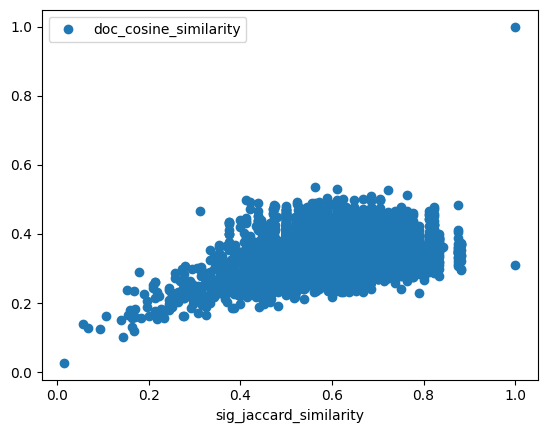

In [46]:
optimal_perm_num = minhash_fine_turn_result['correlation'].max()
minhash_result = permutation_dict[optimal_perm_num]
minhash_result.plot(x='sig_jaccard_similarity', y='doc_cosine_similarity', style='o')

SimHash

Using TF-IDF as document feature. Create a signature matrix using SimHash.
Compare the signature Hamming distance with the document cosine similarity.

In [29]:
tfidf_feature_list = list(tfidf_vectorizer.get_feature_names_out())
feature_hash = get_feature_hash(tfidf_feature_list)
finger_print_list = get_finger_print_list(X_tfidf,feature_hash)

In [30]:
# Check Performance
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)
simhash_result = check_simhash_similarity(finger_print_list,target_doc_num)

simhash_result = tfidf_result.merge(simhash_result,how='outer',on='doc_num')
simhash_result = simhash_result.sort_values(by=['sig_hamming_distance'],ascending=True)

PearsonRResult(statistic=-0.7697501293496969, pvalue=0.0)


<Axes: xlabel='doc_cosine_similarity'>

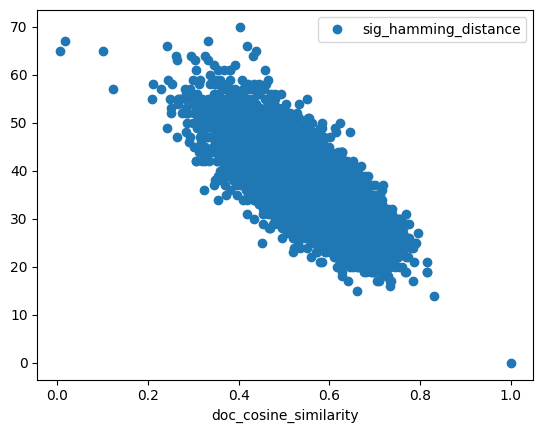

In [45]:
print(pearsonr(simhash_result['doc_cosine_similarity'],simhash_result['sig_hamming_distance']))
simhash_result.plot(x='doc_cosine_similarity', y='sig_hamming_distance', style='o')

Doc2Vec

Word2Vec also need to consider token position for word embeding. Use the original text instead of the processed text for vectorization.

In [32]:
# Use pretrained model to tokenize the documents.
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [33]:
# Use abstract summsry since it has less tokens.
original_docs = list(df['abstract_summary'])
tagged_docs = tag_documents(tokenizer,original_docs)

In [34]:
model = Doc2Vec()
model.build_vocab(tagged_docs)
model.train(tagged_docs,total_examples=model.corpus_count,epochs=20)

doc2vec_result = get_doc2vec_result(model,tokenizer,original_docs,target_doc_num)
doc2vec_result

,doc2vec,doc_num
0,1,0
1,2,6928
2,3,6313
3,4,211
4,5,5648
...,...,...
8036,8037,4928
8037,8038,5774
8038,8039,227
8039,8040,7074


Comparing the performance of different document similarity search methods with the cosine similarity of document with TF-IDF word embeding.


In [49]:
rank_df = get_performance_rank(tfidf_result,count_result,clip_result,minhash_result,simhash_result,doc2vec_result)
rank_diff_df = get_performance_rank_diff(rank_df)

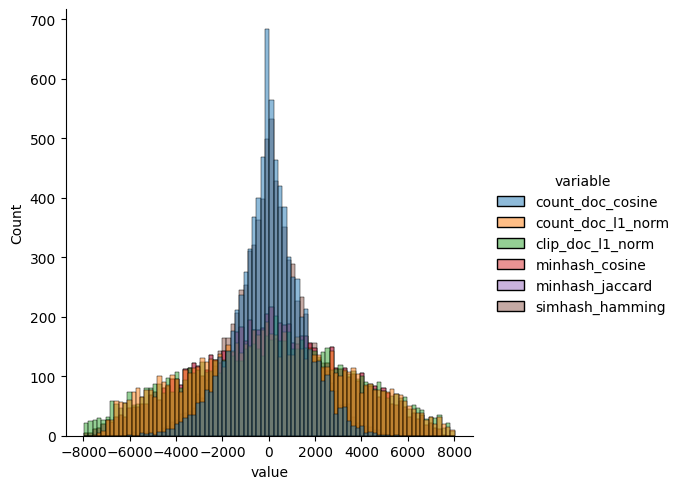

In [52]:
plot_df = rank_diff_df.drop(columns=['doc_num','tfidf_doc_cosine']).melt()
sns.displot(plot_df, x='value', hue='variable')

In [53]:
var_rank_diff = rank_diff_df.drop(columns=['doc_num']).var(axis=0)
var_rank_diff = var_rank_diff.reset_index().rename(columns={'index':'metric',0:'variance'})
var_rank_diff = var_rank_diff.sort_values(by=['variance'],ascending=True)
var_rank_diff

,metric,variance
1,count_doc_cosine,2.089450e+06
6,simhash_hamming,2.670554e+06
0,tfidf_doc_cosine,5.388810e+06
4,minhash_cosine,1.001336e+07
5,minhash_jaccard,1.001336e+07
2,count_doc_l1_norm,1.166310e+07
3,clip_doc_l1_norm,1.258959e+07
